In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.autograd import Variable

import copy

In [2]:
sns.set_context("paper")
sns.set_style("ticks")

np.random.seed(101217209)

In [3]:
def get_data(N, min_x, max_x):
    w, b = np.random.randn(2)
    def true_model(X):
        lin_factor = w * X + b
        y = np.sin(lin_factor*10)*(lin_factor**2)
        return y
    X_true = np.arange(min_x, max_x, 0.01)
    y_true = true_model(X_true)
    span = (max_x - min_x)
    scale = 0.2
    X_obs = min_x + span*scale + np.random.rand(N)*(span - 2*scale*span)
    y_obs = true_model(X_obs) + np.random.randn(N)*0.1
    
    y_mean, y_std = y_obs.mean(), y_obs.std()
    y_obs = (y_obs - y_mean)/y_std
    y_true = (y_true - y_mean)/y_std
    return (X_obs, y_obs, X_true, y_true), (w, b, true_model)

In [4]:
N = 40
min_x, max_x = -1, 1
(X_obs, y_obs, X_true, y_true), (w, b, true_model) = get_data(N, min_x, max_x)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


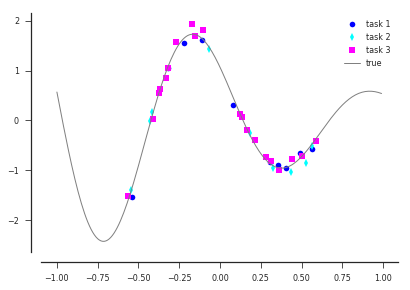

In [5]:
plt.plot(X_obs[:10], y_obs[:10], ls="none", marker="o", color="b", label="task 1")
plt.plot(X_obs[10:20], y_obs[10:20], ls="none", marker="d", color="cyan", label="task 2")
plt.plot(X_obs[20:], y_obs[20:], ls="none", marker="s", color="magenta", label="task 3")
plt.plot(X_true, y_true, ls="-", lw=1, color="0.5", label="true")
plt.legend()
sns.despine(offset=10)

In [6]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p=0.05, decay=0.001):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 20),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

def ewc_criterion(model, fisher_matrix, prior_params, alpha=1):
    ewc_loss = Variable(torch.zeros(1))
    for p, fm, prior in zip(model.parameters(), fisher_matrix, prior_params):
        param_loss = torch.pow(p - Variable(prior, requires_grad=False), 2)
        fisher_scaled_loss = alpha*Variable(fm, requires_grad=False).mul(param_loss)
        ewc_loss += fisher_scaled_loss.sum()
    return ewc_loss    
    
def get_criterion_optimizer(model):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        #lr=0.001,
        #momentum=0.5,
        weight_decay=model.decay)
    return criterion, optimizer

    
def plot_predictions(model, model_simple):
    plt.plot(X_obs[:10], y_obs[:10], ls="none", marker="o", color="b", label="task 1")
    plt.plot(X_obs[10:20], y_obs[10:20], ls="none", marker="d", color="cyan", label="task 2")
    plt.plot(X_obs[20:], y_obs[20:], ls="none", marker="s", color="magenta", label="task 3")
    plt.plot(X_true, y_true, ls="-", lw=1, color="0.5", label="true")

    model.eval()
    y_pred = model(X_true[:, np.newaxis]).data.numpy()
    plt.plot(X_true, y_pred, ls="--", lw=1, color="r", label="ecw")

    model_simple.eval()
    y_pred = model_simple(X_true[:, np.newaxis]).data.numpy()
    plt.plot(X_true, y_pred, ls="--", lw=1, color="g", label="simple")

    plt.legend()
    sns.despine(offset=10)
    
def plot_losses(model, model_simple):
    fig = plt.figure(figsize=(10,4))
    plt.plot(losses, lw=0.1, color='r', label='ecw')
    plt.plot(losses_simple, lw=0.1, color='0.5', label='simple')
    plt.legend()
    sns.despine(offset=10)


def get_fisher_matrix(model, criterion, X, Y, old_fisher_matrix=None):
    fisher_matrix = [torch.zeros(p.data.shape) for p in model.parameters()]
    counts = 0
    #print(X.shape, Y.shape)
    for x,y in zip(X[:, np.newaxis, np.newaxis], Y[:, np.newaxis]):
        criterion.zero_grad()
        #print(x.shape, y.shape)
        y_pred = model(x)
        #print(y_pred.data.shape)
        loss = criterion(y_pred, Variable(torch.Tensor(y), requires_grad=False))
        loss.backward()
        for i, p in enumerate(model.parameters()):
            grad_squared = torch.pow(p.grad.data, 2)
            #print(grad_squared.shape, fisher_matrix[i].shape)
            fisher_matrix[i] += grad_squared
        counts += 1
    #print(grad_squared.shape, fisher_matrix[i].shape)
    ## Calculate the means
    fisher_matrix = [k/counts for k in fisher_matrix]
    if old_fisher_matrix:
        fisher_matrix = [k + o for k,o in zip(fisher_matrix, old_fisher_matrix)]
    return fisher_matrix
    
    
def train_step(model, X, Y, criterion, optimizer, ecw_alpha=0):
    y_pred = model(X[:, np.newaxis])
    loss = criterion(y_pred, Variable(torch.Tensor(Y), requires_grad=False))
    if ecw_alpha > 0:
        ewc_loss = ewc_criterion(model, fisher_matrix, model_params, alpha=ecw_alpha)
        loss += ewc_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(),clip)
    optimizer.step()
    return loss.data.numpy()[0]
    
    

In [7]:
model = SimpleModel(p=0.01, decay=1e-3)
model_simple = copy.deepcopy(model)

In [8]:
model.train()
criterion, optimizer = get_criterion_optimizer(model)

model_simple.train()
criterion_simple, optimizer_simple = get_criterion_optimizer(model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


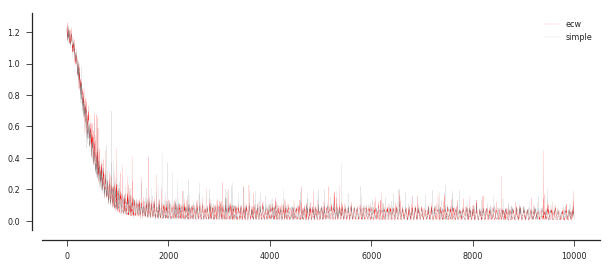

In [9]:
losses = []
losses_simple = []
clip=10
for i in range(10000):
    loss = train_step(model, X_obs[:10], y_obs[:10], criterion, optimizer)
    losses.append(loss)
    
    loss = train_step(
        model_simple, X_obs[:10], y_obs[:10], criterion_simple, optimizer_simple)
    losses_simple.append(loss)
plot_losses(model, model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


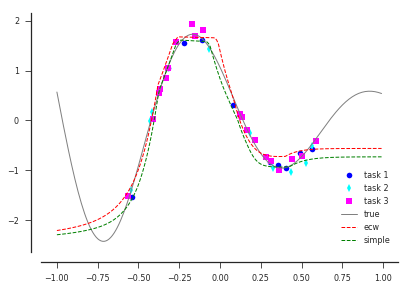

In [10]:
plot_predictions(model, model_simple)

In [11]:
"""
model.eval()
fisher_matrix = get_fisher_matrix(model, criterion, X_obs[:10], y_obs[:10])
model_params = [copy.deepcopy(p.data) for p in model.parameters()]

fig = plt.figure(0)
ax = fig.add_subplot(111)


el = plt.matplotlib.patches.Ellipse(
    xy=[
        model_params[0].squeeze().numpy()[0],
        model_params[1].numpy()[0]
    ],
    width=2./fisher_matrix[0].squeeze().numpy()[0],
    height=2./fisher_matrix[1].numpy()[0])
ax.add_artist(el)
#el.set_clip_box(ax.bbox)
el.set_color('0.5')
el.set_alpha(0.1)
ax.scatter(model_params[0].squeeze().numpy(), model_params[1].numpy(), s=1)
"""

"\nmodel.eval()\nfisher_matrix = get_fisher_matrix(model, criterion, X_obs[:10], y_obs[:10])\nmodel_params = [copy.deepcopy(p.data) for p in model.parameters()]\n\nfig = plt.figure(0)\nax = fig.add_subplot(111)\n\n\nel = plt.matplotlib.patches.Ellipse(\n    xy=[\n        model_params[0].squeeze().numpy()[0],\n        model_params[1].numpy()[0]\n    ],\n    width=2./fisher_matrix[0].squeeze().numpy()[0],\n    height=2./fisher_matrix[1].numpy()[0])\nax.add_artist(el)\n#el.set_clip_box(ax.bbox)\nel.set_color('0.5')\nel.set_alpha(0.1)\nax.scatter(model_params[0].squeeze().numpy(), model_params[1].numpy(), s=1)\n"

In [12]:
model.eval()
fisher_matrix = get_fisher_matrix(model, criterion, X_obs[:10], y_obs[:10])
model_params = [copy.deepcopy(p.data) for p in model.parameters()]

model.train()
criterion, optimizer = get_criterion_optimizer(model)

model_simple.train()
criterion_simple, optimizer_simple = get_criterion_optimizer(model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


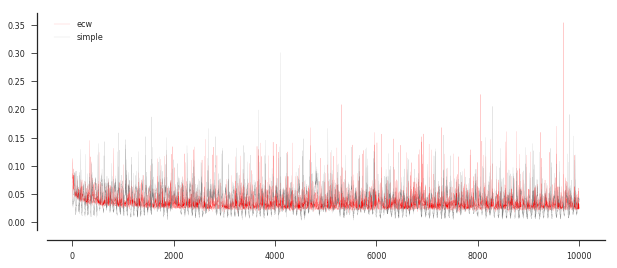

In [13]:
losses = []
losses_simple = []
clip=10
alpha=10
for i in range(10000):
    loss = train_step(model, X_obs[10:20], y_obs[10:20], criterion, optimizer, ecw_alpha=alpha)
    losses.append(loss)
    
    loss = train_step(
        model_simple, X_obs[10:20], y_obs[10:20], criterion_simple, optimizer_simple)
    losses_simple.append(loss)
plot_losses(model, model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


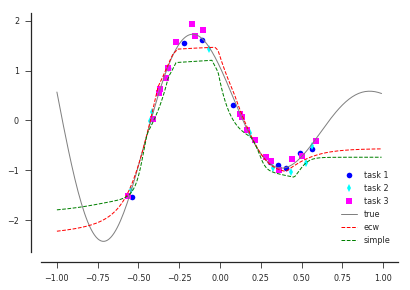

In [14]:
plot_predictions(model, model_simple)

In [15]:
## Task 3
model.eval()
fisher_matrix = get_fisher_matrix(model, criterion, X_obs[10:20], y_obs[10:20], old_fisher_matrix=fisher_matrix)
model_params = [copy.deepcopy(p.data) for p in model.parameters()]

model.train()
criterion, optimizer = get_criterion_optimizer(model)

model_simple.train()
criterion_simple, optimizer_simple = get_criterion_optimizer(model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


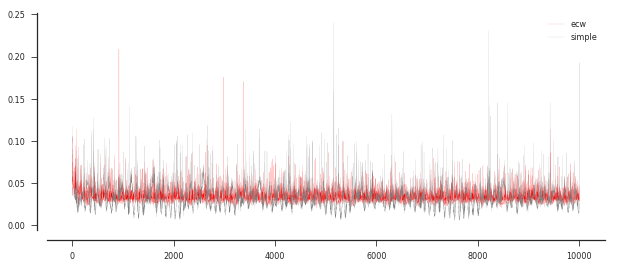

In [16]:
losses = []
losses_simple = []
clip=10
alpha=10
for i in range(10000):
    loss = train_step(model, X_obs[20:], y_obs[20:], criterion, optimizer, ecw_alpha=alpha)
    losses.append(loss)
    
    loss = train_step(
        model_simple, X_obs[20:], y_obs[20:], criterion_simple, optimizer_simple)
    losses_simple.append(loss)
plot_losses(model, model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


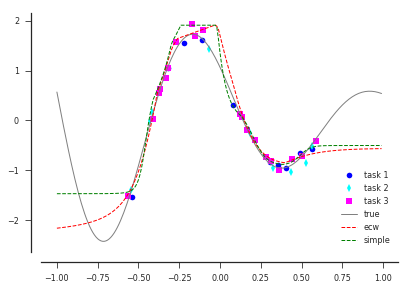

In [17]:
plot_predictions(model, model_simple)

## Sequential data

In [18]:
sorted_idx = np.argsort(X_obs)
X_obs = X_obs[sorted_idx]
y_obs = y_obs[sorted_idx]

In [19]:
model = SimpleModel(p=0.01, decay=1e-3)
model_simple = copy.deepcopy(model)

In [20]:
model.train()
criterion, optimizer = get_criterion_optimizer(model)

model_simple.train()
criterion_simple, optimizer_simple = get_criterion_optimizer(model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


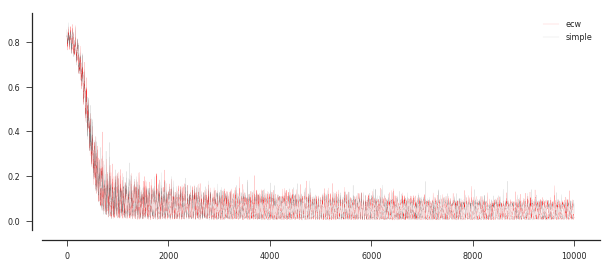

In [21]:
losses = []
losses_simple = []
clip=10
for i in range(10000):
    loss = train_step(model, X_obs[:10], y_obs[:10], criterion, optimizer)
    losses.append(loss)
    
    loss = train_step(
        model_simple, X_obs[:10], y_obs[:10], criterion_simple, optimizer_simple)
    losses_simple.append(loss)
plot_losses(model, model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


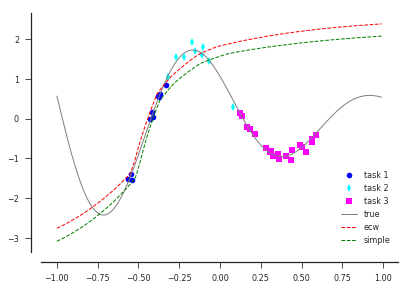

In [22]:
plot_predictions(model, model_simple)

In [23]:
model.eval()
fisher_matrix = get_fisher_matrix(model, criterion, X_obs[:10], y_obs[:10])
model_params = [copy.deepcopy(p.data) for p in model.parameters()]

model.train()
criterion, optimizer = get_criterion_optimizer(model)

model_simple.train()
criterion_simple, optimizer_simple = get_criterion_optimizer(model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


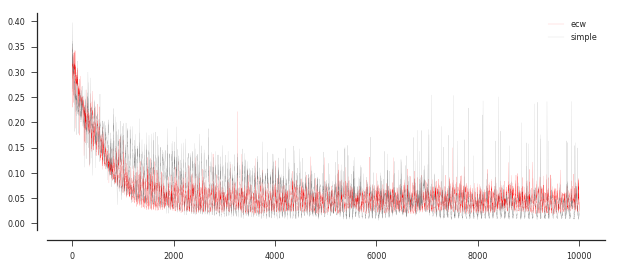

In [24]:
losses = []
losses_simple = []
clip=10
alpha=10
for i in range(10000):
    loss = train_step(model, X_obs[10:20], y_obs[10:20], criterion, optimizer, ecw_alpha=alpha)
    losses.append(loss)
    
    loss = train_step(
        model_simple, X_obs[10:20], y_obs[10:20], criterion_simple, optimizer_simple)
    losses_simple.append(loss)
plot_losses(model, model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


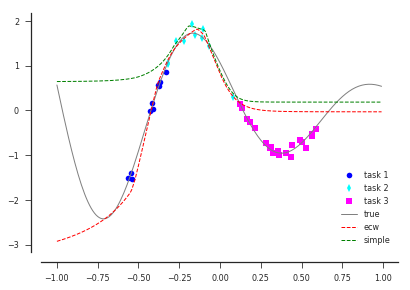

In [25]:
plot_predictions(model, model_simple)

In [26]:
## Task 3
model.eval()
fisher_matrix = get_fisher_matrix(model, criterion, X_obs[10:20], y_obs[10:20], old_fisher_matrix=fisher_matrix)
model_params = [copy.deepcopy(p.data) for p in model.parameters()]

model.train()
criterion, optimizer = get_criterion_optimizer(model)

model_simple.train()
criterion_simple, optimizer_simple = get_criterion_optimizer(model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


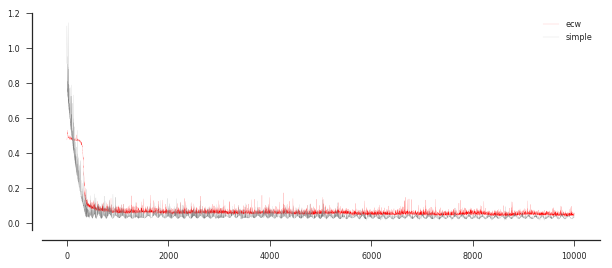

In [27]:
losses = []
losses_simple = []
clip=10
alpha=10
for i in range(10000):
    loss = train_step(model, X_obs[20:], y_obs[20:], criterion, optimizer, ecw_alpha=alpha)
    losses.append(loss)
    
    loss = train_step(
        model_simple, X_obs[20:], y_obs[20:], criterion_simple, optimizer_simple)
    losses_simple.append(loss)
plot_losses(model, model_simple)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


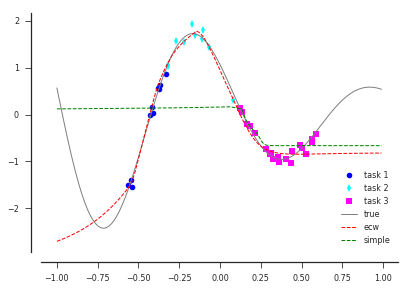

In [28]:
plot_predictions(model, model_simple)